[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sdiciotti/Age-Prediction-Demo/blob/master/Age_prediction.ipynb)

In [1]:
!pip install shap
import ipywidgets as widgets 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, accuracy_score
import shap
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/sdiciotti/Age-Prediction-Demo/main/NKI2_data.csv')
features = list(df.columns)
df_plot = df.copy()
df

,Age,Sex,cortex_CT,lh_cortex_CT,rh_cortex_CT,lh_frontalGM_CT,lh_occipitalGM_CT,lh_temporalGM_CT,lh_parietalGM_CT,rh_frontalGM_CT,...,lh_cerebralGM_FD,lh_frontalGM_FD,lh_temporalGM_FD,lh_parietalGM_FD,lh_occipitalGM_FD,rh_cerebralGM_FD,rh_frontalGM_FD,rh_temporalGM_FD,rh_parietalGM_FD,rh_occipitalGM_FD
0,13,F,2.563765,2.53793,2.58960,2.604,2.084,2.694,2.432,2.573,...,2.4527,2.3947,2.3795,2.3840,2.2441,2.4524,2.4001,2.3942,2.3788,2.2650
1,13,M,2.816775,2.80403,2.82952,2.870,2.265,3.188,2.564,2.914,...,2.4719,2.4216,2.4228,2.3896,2.2861,2.5181,2.4290,2.4202,2.3942,2.2631
2,16,F,2.590785,2.60300,2.57857,2.659,2.058,2.877,2.537,2.649,...,2.4854,2.3733,2.3712,2.3852,2.2485,2.4820,2.3681,2.3633,2.3735,2.2511
3,17,M,2.618340,2.62847,2.60821,2.780,2.057,2.867,2.459,2.739,...,2.4911,2.4034,2.3956,2.3679,2.2631,2.4535,2.3933,2.3921,2.3683,2.2677
4,17,M,2.737575,2.77298,2.70217,2.866,2.137,3.194,2.546,2.716,...,2.5081,2.4224,2.4194,2.3738,2.2687,2.4641,2.4074,2.4158,2.3694,2.2728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,14,F,2.785335,2.80093,2.76974,2.956,2.067,3.147,2.646,2.908,...,2.5180,2.4271,2.4132,2.3892,2.2572,2.5115,2.4230,2.4198,2.3888,2.2743
69,16,M,2.645850,2.62908,2.66262,2.793,2.011,2.912,2.407,2.739,...,2.4936,2.4038,2.4022,2.3601,2.2468,2.5016,2.4025,2.4116,2.3767,2.2491
70,12,F,2.731690,2.73606,2.72732,2.854,2.052,3.025,2.599,2.790,...,2.5094,2.4146,2.3960,2.3848,2.2327,2.5049,2.4108,2.3926,2.3872,2.2519
71,10,F,2.674965,2.67007,2.67986,2.749,2.139,3.098,2.412,2.725,...,2.5044,2.4150,2.3924,2.3717,2.2553,2.5067,2.4107,2.3956,2.3772,2.2743


In [7]:

a = widgets.Dropdown(
    options=features,
    value=features[1],
    description='X:',
    disabled=False,
)
b = widgets.Dropdown(
    options=features,
    value=features[1],
    description='y:',
    disabled=False,
)
display(a,b)


Dropdown(description='X:', index=1, options=('Age', 'Sex', 'cortex_CT', 'lh_cortex_CT', 'rh_cortex_CT', 'lh_fr…

Dropdown(description='y:', index=1, options=('Age', 'Sex', 'cortex_CT', 'lh_cortex_CT', 'rh_cortex_CT', 'lh_fr…

Text(0, 0.5, 'lh_occipitalGM_CT')

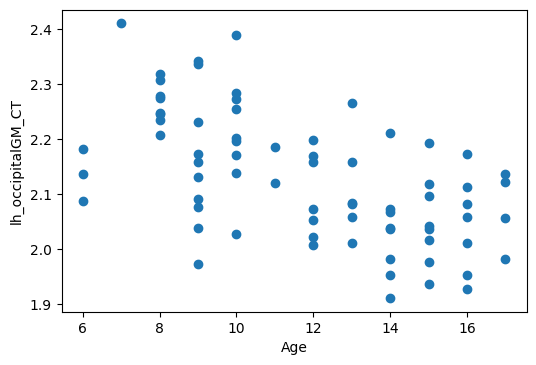

In [9]:
plt.figure(dpi=100)
plt.scatter(df[a.value],df[b.value])
plt.xlabel(a.value)
plt.ylabel(b.value)

In [10]:
print("Dataframe shape before NaN removal:", np.shape(df)[0])

Dataframe shape before NaN removal: 73


In [11]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print("Dataframe shape after NaN removal:", np.shape(df)[0])

Dataframe shape after NaN removal: 72


In [12]:
### REGRESSION ###
print('***Regression task')

SEED = 42
outer_n_folds = 5
inner_n_folds = 5
C = [0.1, 1, 10]

X = df.iloc[:,2::]
shap_X = df.iloc[:,2::]
y = df['Age']

print('The whole dataset contains ' + str(np.shape(df)[0]) + ' subjects')
print('The age prediction will be performed using ' + str(np.shape(X)[1]) + ' MRI-derived features')
print() 

***Regression task
The whole dataset contains 72 subjects
The age prediction will be performed using 33 MRI-derived features



In [13]:
# NestedCV implemented in scikit-learn
outer_cv = KFold(n_splits=outer_n_folds, shuffle=True, random_state=SEED)
inner_cv = KFold(n_splits=inner_n_folds, shuffle=True, random_state=SEED)

clf = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=0.1, epsilon=0.1, shrinking=True, cache_size=200, verbose=0, max_iter=- 1)
p_grid = [{'C': C}]     

X = np.asarray(X)
y = np.asarray(y)

clf_gs = GridSearchCV(clf, param_grid=p_grid, cv=inner_cv, refit='neg_mean_absolute_error', scoring='neg_mean_absolute_error', n_jobs=1, verbose = 4)
nested_score = cross_validate(clf_gs, X=X, y=y, cv=outer_cv, return_train_score=True, return_estimator=True, scoring = 'neg_mean_absolute_error', n_jobs=1)

#print(np.abs(nested_score['train_score']))
#print(np.abs(nested_score['test_score']))
print("Average MAE train:", np.abs(np.mean(nested_score['train_score'])))
print("Average MAE test:", np.abs(np.mean(nested_score['test_score'])))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ............................C=0.1;, score=-2.315 total time=   0.0s
[CV 2/5] END ............................C=0.1;, score=-1.942 total time=   0.0s
[CV 3/5] END ............................C=0.1;, score=-2.458 total time=   0.0s
[CV 4/5] END ............................C=0.1;, score=-3.115 total time=   0.0s
[CV 5/5] END ............................C=0.1;, score=-3.355 total time=   0.0s
[CV 1/5] END ..............................C=1;, score=-1.614 total time=   0.0s
[CV 2/5] END ..............................C=1;, score=-1.297 total time=   0.0s
[CV 3/5] END ..............................C=1;, score=-1.571 total time=   0.0s
[CV 4/5] END ..............................C=1;, score=-2.337 total time=   0.0s
[CV 5/5] END ..............................C=1;, score=-2.101 total time=   0.0s
[CV 1/5] END .............................C=10;, score=-1.444 total time=   0.0s
[CV 2/5] END .............................C=10;, 

# SHAP VALUES

In [15]:
clf_gs.fit(shap_X,y)
model = clf_gs.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ............................C=0.1;, score=-2.632 total time=   0.0s
[CV 2/5] END ............................C=0.1;, score=-2.862 total time=   0.0s
[CV 3/5] END ............................C=0.1;, score=-2.419 total time=   0.0s
[CV 4/5] END ............................C=0.1;, score=-2.105 total time=   0.0s
[CV 5/5] END ............................C=0.1;, score=-2.764 total time=   0.0s
[CV 1/5] END ..............................C=1;, score=-1.965 total time=   0.0s
[CV 2/5] END ..............................C=1;, score=-1.698 total time=   0.0s
[CV 3/5] END ..............................C=1;, score=-1.476 total time=   0.0s
[CV 4/5] END ..............................C=1;, score=-1.353 total time=   0.0s
[CV 5/5] END ..............................C=1;, score=-2.079 total time=   0.0s
[CV 1/5] END .............................C=10;, score=-1.959 total time=   0.0s
[CV 2/5] END .............................C=10;, 

In [16]:
explainer = shap.Explainer(model.predict,shap_X)
shap_values = explainer(shap_X)

Permutation explainer: 73it [00:22,  1.97it/s]                        


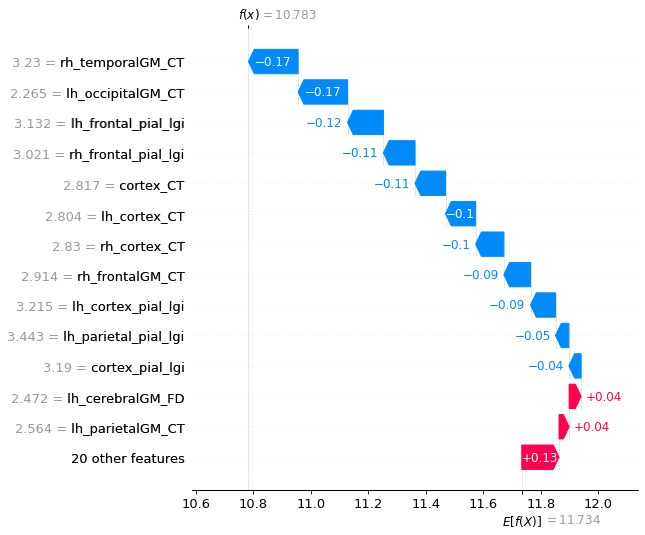

In [17]:
shap.plots.waterfall(shap_values[1], max_display=14)

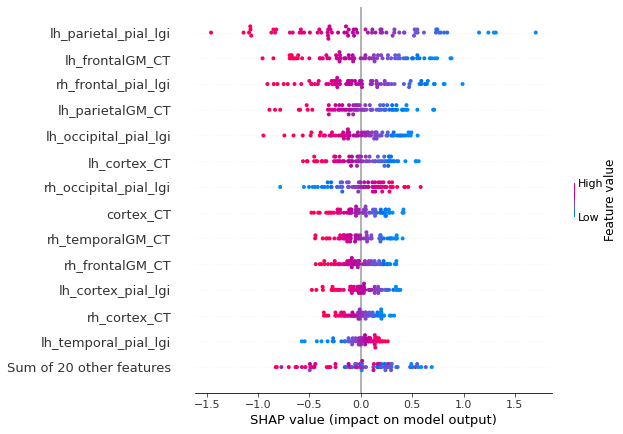

In [18]:
shap.plots.beeswarm(shap_values, max_display=14)

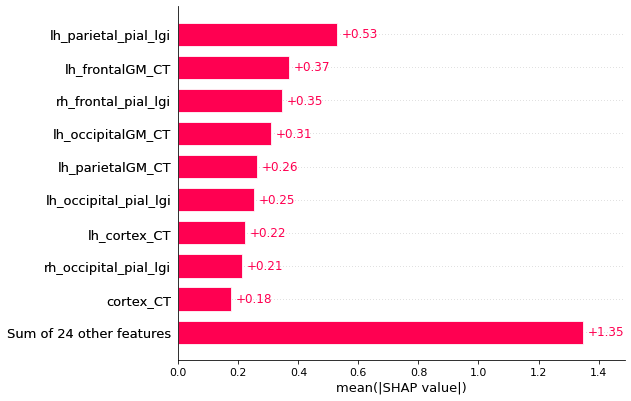

In [19]:
shap.plots.bar(shap_values)

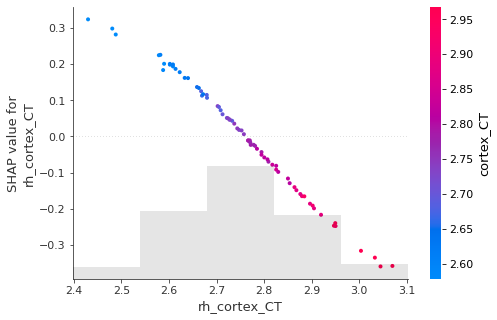

In [20]:
shap.plots.scatter(shap_values[:,"rh_cortex_CT"], color=shap_values)

# CLASSIFICATION OF THE AGE

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/sdiciotti/Age-Prediction-Demo/main/NKI2_data.csv')
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)


In [22]:
df["Age"].unique()

array([13, 16, 17, 12, 14,  9, 11, 15,  6, 10,  8,  7])

In [23]:
bin_age = []
index = []
for i, age in enumerate(df["Age"]):
    if age <=10: 
        bin_age.append(0)
        index.append(i)
        
    elif age >=12: 
        bin_age.append(1)
        index.append(i)

In [24]:
df = df.iloc[index]
df["bin_age"] = bin_age
del df["Age"]

In [25]:
df

,Sex,cortex_CT,lh_cortex_CT,rh_cortex_CT,lh_frontalGM_CT,lh_occipitalGM_CT,lh_temporalGM_CT,lh_parietalGM_CT,rh_frontalGM_CT,rh_occipitalGM_CT,...,lh_frontalGM_FD,lh_temporalGM_FD,lh_parietalGM_FD,lh_occipitalGM_FD,rh_cerebralGM_FD,rh_frontalGM_FD,rh_temporalGM_FD,rh_parietalGM_FD,rh_occipitalGM_FD,bin_age
0,F,2.563765,2.53793,2.58960,2.604,2.084,2.694,2.432,2.573,2.213,...,2.3947,2.3795,2.3840,2.2441,2.4524,2.4001,2.3942,2.3788,2.2650,1
1,M,2.816775,2.80403,2.82952,2.870,2.265,3.188,2.564,2.914,2.244,...,2.4216,2.4228,2.3896,2.2861,2.5181,2.4290,2.4202,2.3942,2.2631,1
2,F,2.590785,2.60300,2.57857,2.659,2.058,2.877,2.537,2.649,2.083,...,2.3733,2.3712,2.3852,2.2485,2.4820,2.3681,2.3633,2.3735,2.2511,1
3,M,2.618340,2.62847,2.60821,2.780,2.057,2.867,2.459,2.739,2.129,...,2.4034,2.3956,2.3679,2.2631,2.4535,2.3933,2.3921,2.3683,2.2677,1
4,M,2.737575,2.77298,2.70217,2.866,2.137,3.194,2.546,2.716,2.204,...,2.4224,2.4194,2.3738,2.2687,2.4641,2.4074,2.4158,2.3694,2.2728,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,M,2.745725,2.74800,2.74345,2.947,2.021,3.044,2.589,2.864,2.104,...,2.4355,2.4243,2.4151,2.2684,2.5178,2.4338,2.4212,2.3990,2.2805,1
68,F,2.785335,2.80093,2.76974,2.956,2.067,3.147,2.646,2.908,2.137,...,2.4271,2.4132,2.3892,2.2572,2.5115,2.4230,2.4198,2.3888,2.2743,1
69,M,2.645850,2.62908,2.66262,2.793,2.011,2.912,2.407,2.739,2.192,...,2.4038,2.4022,2.3601,2.2468,2.5016,2.4025,2.4116,2.3767,2.2491,1
70,F,2.731690,2.73606,2.72732,2.854,2.052,3.025,2.599,2.790,2.216,...,2.4146,2.3960,2.3848,2.2327,2.5049,2.4108,2.3926,2.3872,2.2519,1


In [38]:
### CLASSIFICATION ###
print('***Classification task')

SEED = 42
outer_n_folds = 5
inner_n_folds = 5
C = [0.1, 1, 10]

X = df.iloc[:,1::]
del X["bin_age"]
shap_X = df.iloc[:,1::]
del shap_X["bin_age"]
y = df['bin_age']

print('The whole dataset contains ' + str(np.shape(df)[0]) + ' subjects')
print('The age prediction will be performed using ' + str(np.shape(X)[1]) + ' MRI-derived features')
print() 

***Classification task
The whole dataset contains 71 subjects
The age prediction will be performed using 33 MRI-derived features



In [39]:
# NestedCV implemented in scikit-learn
outer_cv = KFold(n_splits=outer_n_folds, shuffle=True, random_state=SEED)
inner_cv = KFold(n_splits=inner_n_folds, shuffle=True, random_state=SEED)

#clf = SVC(degree=3, gamma='scale', coef0=0.0, tol=0.001, C=0.1,  shrinking=True, cache_size=200, verbose=0, max_iter=- 1)
#p_grid = [{'C': C}]     
clf = XGBClassifier(verbosity=0)
gamma = [0.1,0.2,0.3]
p_grid =[{"gamma":gamma}]
X = np.asarray(X)
y = np.asarray(y)

clf_gs = GridSearchCV(clf, param_grid=p_grid, cv=inner_cv, refit='roc_auc', scoring='roc_auc', n_jobs=1, verbose = 4)
nested_score = cross_validate(clf_gs, X=X, y=y, cv=outer_cv, return_train_score=True, return_estimator=True, scoring = 'roc_auc', n_jobs=1)

#print(np.abs(nested_score['train_score']))
#print(np.abs(nested_score['test_score']))
print("Average ROC AUC train:", np.abs(np.mean(nested_score['train_score'])))
print("Average ROC AUC test:", np.abs(np.mean(nested_score['test_score'])))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .........................gamma=0.1;, score=0.938 total time=   0.1s
[CV 2/5] END .........................gamma=0.1;, score=0.893 total time=   0.1s
[CV 3/5] END .........................gamma=0.1;, score=0.889 total time=   0.1s
[CV 4/5] END .........................gamma=0.1;, score=0.967 total time=   0.1s
[CV 5/5] END .........................gamma=0.1;, score=0.839 total time=   0.0s
[CV 1/5] END .........................gamma=0.2;, score=0.891 total time=   0.0s
[CV 2/5] END .........................gamma=0.2;, score=0.893 total time=   0.1s
[CV 3/5] END .........................gamma=0.2;, score=0.889 total time=   0.0s
[CV 4/5] END .........................gamma=0.2;, score=1.000 total time=   0.0s
[CV 5/5] END .........................gamma=0.2;, score=0.839 total time=   0.0s
[CV 1/5] END .........................gamma=0.3;, score=0.938 total time=   0.0s
[CV 2/5] END .........................gamma=0.3;,

# SHAP VALUES

In [40]:
clf_gs.fit(shap_X,y)
model = clf_gs.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .........................gamma=0.1;, score=0.963 total time=   0.1s
[CV 2/5] END .........................gamma=0.1;, score=0.816 total time=   0.2s
[CV 3/5] END .........................gamma=0.1;, score=0.896 total time=   0.1s
[CV 4/5] END .........................gamma=0.1;, score=0.938 total time=   0.1s
[CV 5/5] END .........................gamma=0.1;, score=0.875 total time=   0.1s
[CV 1/5] END .........................gamma=0.2;, score=0.963 total time=   0.1s
[CV 2/5] END .........................gamma=0.2;, score=0.816 total time=   0.0s
[CV 3/5] END .........................gamma=0.2;, score=0.833 total time=   0.0s
[CV 4/5] END .........................gamma=0.2;, score=0.958 total time=   0.0s
[CV 5/5] END .........................gamma=0.2;, score=0.875 total time=   0.0s
[CV 1/5] END .........................gamma=0.3;, score=0.963 total time=   0.2s
[CV 2/5] END .........................gamma=0.3;,

In [41]:
explainer = shap.TreeExplainer(model,shap_X,feature_perturbation='interventional', model_output='probability')
shap_values = explainer(shap_X)

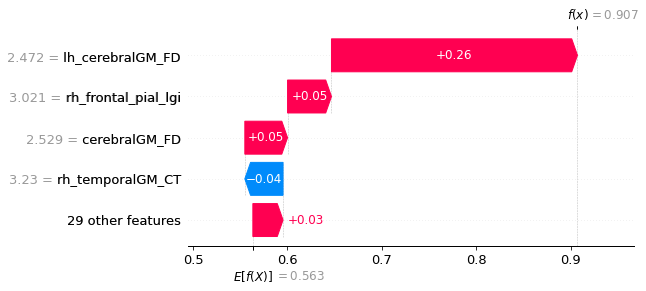

In [42]:
shap.plots.waterfall(shap_values[1], max_display=5)

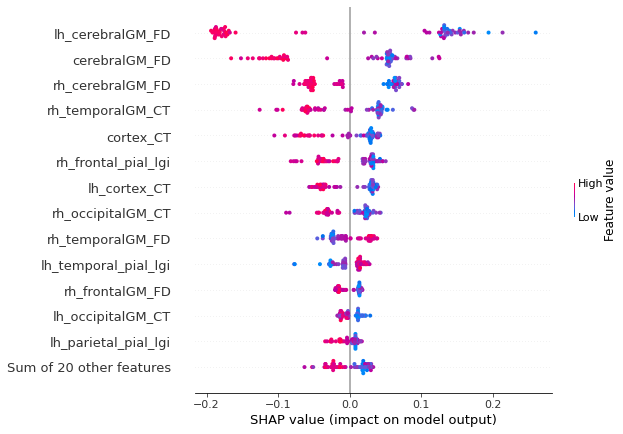

In [43]:
shap.plots.beeswarm(shap_values, max_display=14)

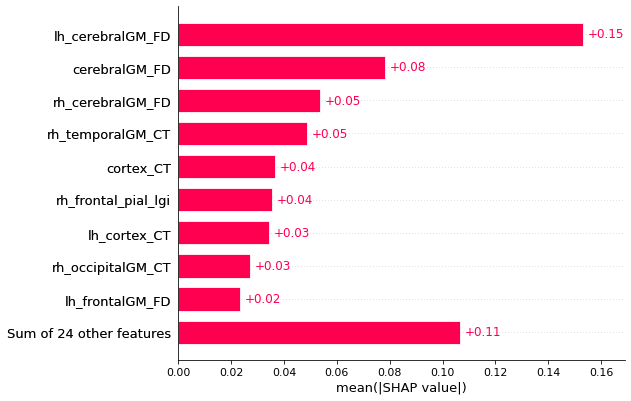

In [44]:
shap.plots.bar(shap_values)

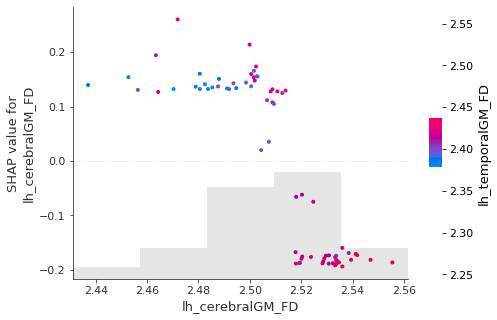

In [45]:
shap.plots.scatter(shap_values[:,"lh_cerebralGM_FD"], color=shap_values)